# Read Various Data Types from Database

Again, make sure you connect to the isaac database

In [1]:
from pyArango.connection import *

# Connect to the database
conn = Connection(arangoURL="http://iui_arangodb:8529", username="root", password="isaac")

# Open the isaac database / create it if it does not exist
if not conn.hasDatabase("isaac"):
    print("There is no isaac database, did you load it?")
else:
    db = conn["isaac"]
    print("Connected to database")

Connected to database


Check which collections are available to read from:

Read 1D Data
================

To read signal data from the database you can filter by timestamp:

In [2]:
import matplotlib.pyplot as plt


# Edit timestamps timestamp
start_time = 0
end_time = 99999999999
ros_topic = "/gnc/ekf"

aql = ""
if start_time is not None and end_time is not None:
    ros_topic = ros_topic.replace("/", "_")[1:]

    aql = "FOR doc IN " + ros_topic + "\n"\
        + "\tFILTER doc.message.header.stamp.secs >= " + str(start_time) + \
              " AND doc.message.header.stamp.secs <= " + str(end_time) + "\n" \
        + "\tRETURN doc.message";

result = list(db.AQLQuery(aql, rawResults = True))


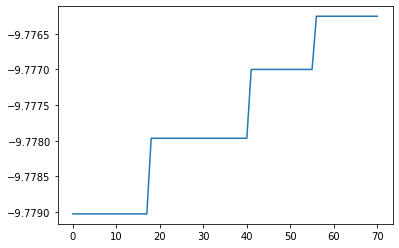

In [3]:


# Plot the robot's position during the time interval
time = [msg.get("header").get("stamp").get("secs") - result[0].get("header").get("stamp").get("secs") for msg in result] 
pos_x = [msg.get("pose").get("position").get("x") for msg in result]
pos_y = [msg.get("pose").get("position").get("y") for msg in result]
pos_z = [msg.get("pose").get("position").get("z") for msg in result]

# plt.plot(time,pos_x)
plt.plot(pos_y[:30000])
# plt.plot(time,pos_z)

Read 2D Data
===========
To read data like images:

In [4]:


# Edit timestamps timestamp
start_time = 1616777590
end_time = 1616777600
ros_topic = "/mgt/img_sampler/nav_cam/image_record"


aql = ""
if start_time is not None and end_time is not None:
    ros_topic = ros_topic.replace("/", "_")[1:]

    aql = "FOR doc IN " + ros_topic + "\n"\
        + "\tFILTER doc.message.header.stamp.secs >= " + str(start_time) + \
              " AND doc.message.header.stamp.secs <= " + str(end_time) + "\n" \
        + "\tRETURN doc.message";

result = db.AQLQuery(aql, rawResults = True)


In [5]:
# Convert image to ros message
from sensor_msgs.msg import Image
import genpy

expect = Image()
expect_str = result[0]
genpy.message.fill_message_args(expect, expect_str)
expect.data = bytes(expect.data)


# View image
import cv2
import numpy as np
from cv_bridge import CvBridge, CvBridgeError

bridge = CvBridge()
cv_image = bridge.imgmsg_to_cv2(expect, "mono8")

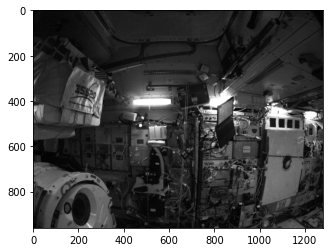

In [6]:
from matplotlib import pyplot as plt

plt.imshow(cv_image, cmap='gray', vmin=0, vmax=255)
plt.show()